# Unsupervised Text Classification of Sarcastic Comments in Python

Abhiram Tirumala, Rohith Sudhakar, Satvik Katla, Nevin Gilbert

### Objective

In this Notebook, we explore unsupervised text classification for the purposes of being able to develop a Machine Learning model to detect sarcasm in natural language.

In [2]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import string
import multiprocessing
from gensim.models import Word2Vec
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import spacy
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from scipy import spatial
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Dataset Preprocessing
The dataset we will use is a compilation of both sarcastic and not sarcastic comments scraped from Reddit. This dataset was published under Kaggle and can be found here:

https://www.kaggle.com/sachinichake/detect-sarcasm-in-comments?select=Train.csv

Here we fetch the dataset from our public GitHub repository and store it as a Pandas DataFrame.

In [3]:
!wget https://raw.githubusercontent.com/abhitirumala/CS4641-Term-Project/master/datasets/detect_sarcasm_in_comments/Train.csv
df = pd.read_csv('Train.csv')
df

--2020-11-06 18:22:52--  https://raw.githubusercontent.com/abhitirumala/CS4641-Term-Project/master/datasets/detect_sarcasm_in_comments/Train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3647830 (3.5M) [text/plain]
Saving to: ‘Train.csv’

Train.csv           100%[===================>]   3.48M  12.1MB/s    in 0.3s    

2020-11-06 18:22:53 (12.1 MB/s) - ‘Train.csv’ saved [3647830/3647830]



,ID,comment,date,down,parent_comment,score,top,topic,user,label
0,uid_590555,"Well, let's be honest here, they don't actuall...",2015-04,0,They should shut the fuck up and let the commu...,2,2,starcitizen,Combat_Wombatz,0
1,uid_671762,"Well, I didn't need evidence to believe in com...",2016-12,-1,You need evidence to kill people? I thought we...,6,-1,EnoughCommieSpam,starkadd,1
2,uid_519689,"Who does an ""official promo"" in 360p?",2013-11,0,2014 BMW S1000R: Official Promo,3,3,motorcycles,phybere,0
3,uid_788362,Grotto koth was the best,2015-09,0,Not really that memorable lol if you want memo...,2,2,hcfactions,m0xyMC,1
4,uid_299252,Neal's back baby,2015-11,0,James Neal hit on Zach Parise,-5,-5,hockey,Somuch101,1
...,...,...,...,...,...,...,...,...,...,...
14995,uid_845344,Well with a name like El Cubano I'm surprised ...,2015-01,0,There's two things you don't do in Florida. - ...,18,18,hockey,shutupisaac,0
14996,uid_757880,... This is a good point.,2014-04,0,Sounds like a pretty good overall summary of o...,6,6,hockey,em483,0
14997,uid_724706,Yep.,2015-09,0,"I know the type you speak of. The ""die cis scu...",2,2,AskReddit,YoImAli,0
14998,uid_1006984,That's what the government WANTS you to believe!,2016-01,0,That there's A hidden cure for cancer but phar...,1,1,AskReddit,OhHiGCHQ,1


### Data Visualization
labels are stored in a binary format where 1 represents a sarcastic comment, and 0 represents a non-sarcastic comment.

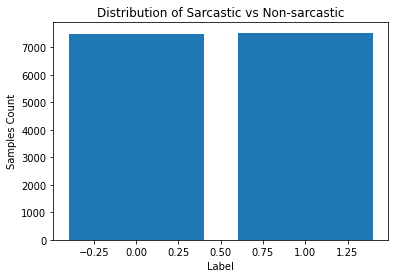

In [4]:
# Check the frequency of each label
label1 = len(df[df['label'] == 1])
label0 = len(df[df['label'] == 0])
plt.bar(x=[1, 0], height=[label1, label0])
plt.title("Distribution of Sarcastic vs Non-sarcastic")
plt.xlabel("Label")
plt.ylabel("Samples Count")
plt.show()

Visualize the correlation between a sarcastic comment and the upvote score associated with it. There doesnt seem to be a correlation between these two features.

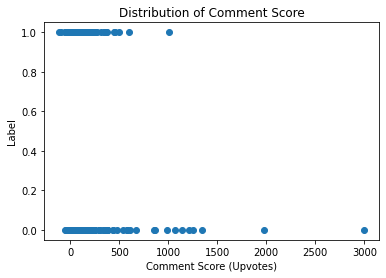

In [5]:
plt.scatter(df['score'], df['label'])
plt.title("Distribution of Comment Score")
plt.xlabel("Comment Score (Upvotes)")
plt.ylabel("Label")
plt.show()

Since no direct correlation between score and the label exists, we can drop it as an unecessary feature. Similarly, we drop the User ID, comment date, no. of downvotes, top, and the username as they are irrelevant features and/or are too difficult to accurately incorporate in the model.

In [7]:
df = df.drop(columns=['ID', 'date', 'down', 'top', 'user'])
df

,comment,parent_comment,score,topic,label
0,"Well, let's be honest here, they don't actuall...",They should shut the fuck up and let the commu...,2,starcitizen,0
1,"Well, I didn't need evidence to believe in com...",You need evidence to kill people? I thought we...,6,EnoughCommieSpam,1
2,"Who does an ""official promo"" in 360p?",2014 BMW S1000R: Official Promo,3,motorcycles,0
3,Grotto koth was the best,Not really that memorable lol if you want memo...,2,hcfactions,1
4,Neal's back baby,James Neal hit on Zach Parise,-5,hockey,1
...,...,...,...,...,...
14995,Well with a name like El Cubano I'm surprised ...,There's two things you don't do in Florida. - ...,18,hockey,0
14996,... This is a good point.,Sounds like a pretty good overall summary of o...,6,hockey,0
14997,Yep.,"I know the type you speak of. The ""die cis scu...",2,AskReddit,0
14998,That's what the government WANTS you to believe!,That there's A hidden cure for cancer but phar...,1,AskReddit,1


### Text Preprocessing
Here we define a function to get rid of punctuation and stop words in each comment. punctuation is often too difficult to incorporate in a model since they are often used in varying ways. Stop words are defined as words that contribute very little to the meaning and sentiment of a sentence, and can be removed in  order to save on computation power.

Here we use the NLTK library's stop words list to clean each string.

In [8]:
text = df['comment'].sample(1).values[0]
text = "Yay! That's amazing!"
print('\nOriginal: ', text)

punctuation = "\"#$%&'()*+-/:;<=>?@[\\]^_`{|}~"
excluded = "!,."

def clean_string(text):
    stemmer = WordNetLemmatizer()
    nopunc = [char.lower() for char in text if char not in punctuation]
    x = []
    for char in nopunc:
      if char in excluded:
        x.append(" " + char)
      else:
        x.append(char)
    nopunc = x
    nopunc = ''.join(nopunc).split()
    # nopunc =  [word.lower() for word in nopunc.split() if word not in stopwords.words('english')]
    nopunc = [stemmer.lemmatize(word) for word in nopunc]
    if nopunc == []:
      return None
    return nopunc

print('Modified: ', clean_string(text))


Original:  Yay! That's amazing!
Modified:  ['yay', '!', 'thats', 'amazing', '!']


## Sentence Embeddings/Vectorization

One of the biggest challenges in Natural Language Processing is computer being able to understand human writing and speech. Many have thought of solutions to mitigate this concern, but perhaps the most effective way is the concept of Word/Sentence Embeddings. Essentially, Embeddings provide a way to convert a sentence  (which is a merely a series of words) into an N-dimensional vector representation. Using an algorithm like *Word2Vec* or *Doc2Vec*, word/sentence vectors can be trained and generated such that words and sentences that have similar sentiment have similar vector representations (which can be calculated through a simple cosine formula). 

### Data Preparation for Gensim Doc2Vec

Here, we prepare a sample our comment data to train a GenSim Doc2Vec model and use it to vectorize our entire dataset.

In [9]:
comments_clean = df['comment'].apply(clean_string).dropna()
# Use a subset of 4000 comments to train
Xtrain = comments_clean.sample(n=4000).values
tagged_data = [TaggedDocument(d, [i]) for i, d in enumerate(Xtrain)]
tagged_data[:5]

[TaggedDocument(words=['dont', 'go', 'bringing', 'your', 'well', 'thought', 'out', 'logic', 'into', 'this', 'thread', '.', '.', 'when', 'reddit', 'rage', ',', 'it', 'rage', 'united', '.'], tags=[0]),
 TaggedDocument(words=['consider', 'this', 'what', 'if', 'you', 'couldnt', 'convince', 'someone', 'to', 'stop', 'believing', 'in', 'god', ',', 'but', 'you', 'could', 'convince', 'them', 'to', 'stop', 'believing', 'god', 'want', 'them', 'to', 'treat', 'people', 'like', 'shit'], tags=[1]),
 TaggedDocument(words=['damn', ',', 'murray', 'throwing', 'to', 'aj', 'green', 'again', 'that', 'just', 'isnt', 'fair'], tags=[2]),
 TaggedDocument(words=['hell', 'yes', ',', 'when', 'going', 'out', 'for', 'a', 'steak', 'is', 'normal', 'and', 'not', 'a', 'very', 'rare', 'luxurious', 'treat', ',', 'ill', 'know', 'im', 'doing', 'really', 'damn', 'well', 'for', 'myself', '.'], tags=[3]),
 TaggedDocument(words=['yea', ',', 'ddosing', 'is', 'a', 'bad', 'a', 'killing', 'someone'], tags=[4])]

### Model Training

We train our model to vectorize our comments into a 200 x 1 vector. After training a simple neural network, we able to determine vectors for any sentence we provide to the model. This will be used to convert our entire comment dataset for unsupervised learning.

In [10]:
model = Doc2Vec(dm=0, vector_size=400, window=15, hs=0, negative=5,
                min_count=5, dbow_words=1, sample=1e-5,
                workers=multiprocessing.cpu_count()-1)
model.build_vocab(tagged_data)
model.train(tagged_data, total_examples=model.corpus_count, epochs=500)
# model.wv.vocab

Provided is an example of a sentence embedding of the phrase "violent means to destroy the organization."

In [11]:
print(model.infer_vector(['violent', 'means', 'to', 'destroy', 'the','organization']))

[ 5.57227731e-02  4.36199792e-02  1.36682494e-02 -8.64162948e-03
  7.23028323e-03 -1.12451485e-03  4.48717475e-02 -5.73232165e-03
  1.84041318e-02  1.05078835e-02 -7.25996564e-04 -3.75867561e-02
  4.65361327e-02  5.76509349e-02  1.65221933e-02  3.44471424e-03
 -2.98186131e-02  2.73290165e-02  6.89762994e-04  8.90335534e-03
  1.12840487e-03 -2.53345631e-03 -7.60449981e-03  2.50779744e-02
 -5.35327103e-03 -1.24037033e-03 -2.05105226e-02  1.19001279e-02
 -6.53318013e-04  1.99889597e-02  1.31335817e-02  2.86385287e-02
 -3.21284868e-02 -2.55808863e-03  4.01575714e-02 -2.63194479e-02
 -6.05307240e-03 -2.69372892e-02  2.11126711e-02 -7.03673949e-03
 -4.19853866e-04  4.30812826e-03 -4.11134660e-02  1.24799705e-03
  4.09875624e-03 -4.07606550e-02  2.55087540e-02  9.98792797e-03
 -3.65615413e-02  8.36105645e-03  3.99589464e-02 -4.31554802e-02
 -1.06964838e-02 -2.61084642e-02 -1.28854280e-02  7.61315459e-03
  5.98836341e-04 -1.84168164e-02 -5.19423634e-02  3.79303098e-02
 -4.10399772e-02 -1.23101

After training the model, we infer a vector for each comment in the preprocessed dataset.

In [12]:
comment_embeddings = np.array([model.infer_vector(sent) for sent in comments_clean.values])
comment_embeddings.shape

(14995, 400)

### Correlation Between Comments and Parent Comments

As a side exploration, we tried to find a correlation between the similarity of a reddit comment and the parent comment associated with it. In this 5 comment sample, we are unable to determine any immediate correlation, but perhaps which more analysis, we may find some more itneresting results.

In [13]:
com_sample = df.sample(5).values

for row in com_sample:
  com, par_com, label = row[[0, 1, -1]]
  print("\nComment:", com)
  print("Parent Comment:", par_com)
  print("Sarcastic:", label)
  com, par_com = clean_string(com), clean_string(par_com)


  vec1 = model.infer_vector(com)
  vec2 = model.infer_vector(par_com)

  similarity = spatial.distance.cosine(vec1, vec2)
  print("Approximate Similarity:", 1 - similarity)


Comment: More importantly, how do I get MY son into pirates?
Parent Comment: My two year old son is into pirates, so for his birthday I built him a cannon complete with an android app to simulate lighting the fuse and firing the cannonball.
Sarcastic: 0
Approximate Similarity: 0.5940667390823364

Comment: It's their job, would it be any better if they went about it with grim faces?
Parent Comment: Not to be spoil sports here but assembly line ones atleast don't have salivating humans getting a kick out of killing the animals.
Sarcastic: 0
Approximate Similarity: 0.23678329586982727

Comment: Would love one, buddy, pretty pretty please!
Parent Comment: I got 11 grombrindal the white dwarf keys
Sarcastic: 0
Approximate Similarity: 0.40393954515457153

Comment: So sorry single white mom just trying to pay the bills and keep food on the table, your free ride is over.
Parent Comment: SJW refuses to tip white waiters
Sarcastic: 1
Approximate Similarity: 0.3915777802467346

Comment: I'd turn

## Unsupervised Learning (KMeans Clustering)

In our unsupervised model, we intend to classify each comment into clusters representing the similarity comments. For this, we use the KMeans Clustering Algorithm implementation in the *SciKit-Learn* Machine Learning library.

Using the sentence embeddings generated earlier, our goal in this KMeans analysis is to cluster comments by sentiment simialrity to find a correlation between cluster assignment and whether or not the comment was sarcastic.

In [16]:
from sklearn.cluster import KMeans

### KMeans Elbow Method

To determine the optimal number of clusters, we employ the Elbow Method. This method is to find a number of clusters *k* such that increasing the value of *k* results in diminishing returns of loss reduction.

Clusters: 74 	Final Loss:41454.6589

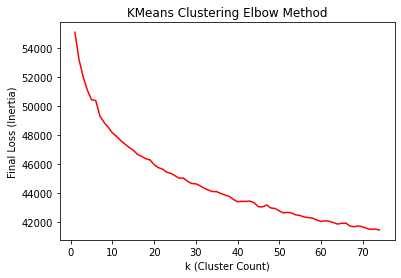

In [17]:
ssqd = []
K = range(1, 75, 1)

for k in K:
    kmeans_model = KMeans(n_clusters=k,
                  init='k-means++', 
                  max_iter=1000,
                  n_init=1)
    iter = kmeans_model.fit(comment_embeddings)
    print(f"\rClusters: {k} \tFinal Loss:{iter.inertia_:.4f}", end="")
    ssqd.append(iter.inertia_)
  
plt.plot(K, ssqd, 'r-')
plt.title('KMeans Clustering Elbow Method')
plt.xlabel('k (Cluster Count)')
plt.ylabel('Final Loss (Inertia)')
plt.show()

In [18]:
k_min = 15
kmeans_model = KMeans(n_clusters=k_min,
               init='k-means++', 
               max_iter=100,
               n_init=1)
kmeans_model.fit(comment_embeddings)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=100,
       n_clusters=15, n_init=1, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

### Cluster Assignment vs Sarcastic Label

Lastly, we choose to draw a comparison between our unsupervised learning algorithms and the label data corresponding to each comment. For all the clusters, we find that there is no defining way to seperate sarcastic comments from non-sarcastic comments using this implementation.

Cluster 0
Size of cluster: 965


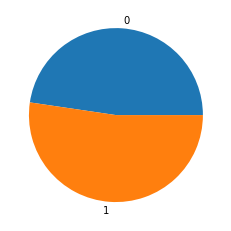

Cluster 1
Size of cluster: 1270


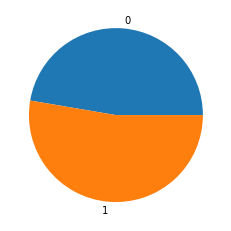

Cluster 2
Size of cluster: 1121


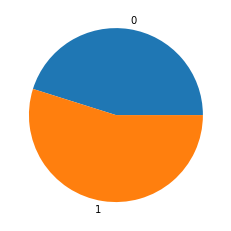

Cluster 3
Size of cluster: 934


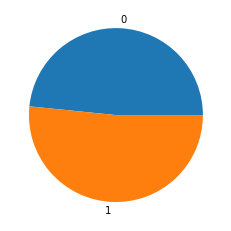

Cluster 4
Size of cluster: 1012


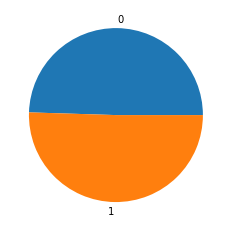

Cluster 5
Size of cluster: 788


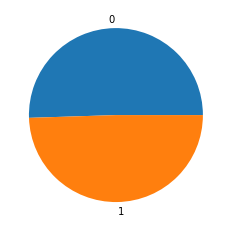

Cluster 6
Size of cluster: 943


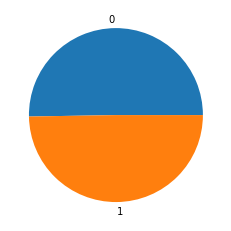

Cluster 7
Size of cluster: 722


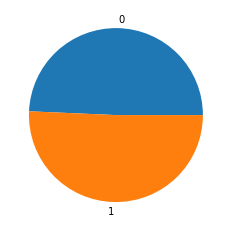

Cluster 8
Size of cluster: 734


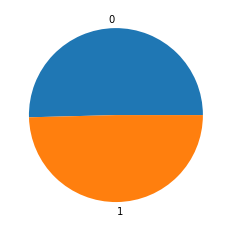

Cluster 9
Size of cluster: 723


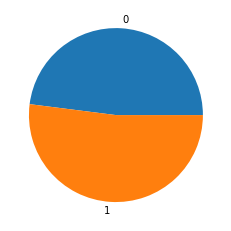

Cluster 10
Size of cluster: 585


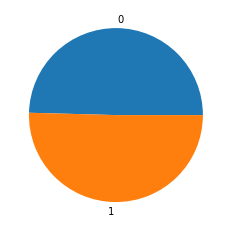

Cluster 11
Size of cluster: 2514


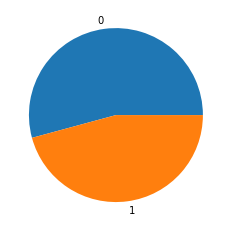

Cluster 12
Size of cluster: 543


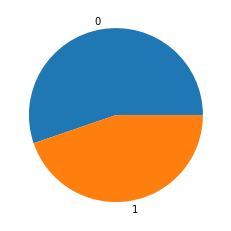

Cluster 13
Size of cluster: 1108


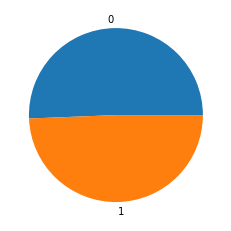

Cluster 14
Size of cluster: 1033


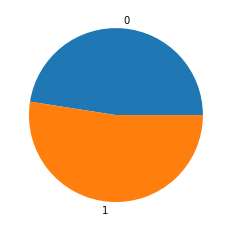

In [21]:
# fig, axs = plt.subplots(nrows=3, ncols=5)
X, label = comment_embeddings, df['label'].values
cluster = kmeans_model.predict(X)
for k in range(k_min):
  print(f"Cluster {k}")
  l = label[np.where(cluster == k)]
  print(f"Size of cluster: {len(l)}")
  count0 = len(np.where(l == 0)[0])
  count1 = len(np.where(l == 1)[0])
  plt.pie([count0, count1], labels=[0, 1])
  plt.show()
